In [11]:
%load_ext autoreload
from ddls.plotting.plotting import plot_line, plot_bar, plot_hist, PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st

import gzip
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# set paths to agent(s)

base_folder = '/scratch/datasets/ddls/sims/'

# base_name = 'job_placing'
# # ids = [108]
# ids = [108, 116]

# base_name = 'ramp_job_placement_shaping'
base_name = 'ramp_job_partitioning'
agent_to_id = {
    # 'RL': 385,
    
    # # 5 'small' graphs (image classification and NMT) -> 1000 in an episode (replication_factor=200)
    # 'RL-JCT': 437, # reward=lookahead_job_completion_time
    # 'RL-Acc': 440, # reward=job_acceptance
    
    
    
    
    # RAMP_JOB_PARTITIONING
    
    # 200 AlexNet, max_partitions_per_op=None
    # 'RL\n(JCT)': 104,
    # 'RL\n(Acc)': 103,
    
    # 'FRF-1': 207,
    # 'FRF-10': 209,
    # 'FRF-100': 208,
    
    # 'RL': 272,
    
    # 'RL': 311
    
    # 'RL-442': 442,
    # 'RL-446': 446,
    
    'neat-sweep-75': 518,
    
}

In [40]:
# load data

episode_metrics = {
    'num_jobs_arrived',
    'num_jobs_completed',
    'num_jobs_blocked',
    
    'mean_compute_throughput',
    'mean_comm_throughput',
    'mean_cluster_throughput',
    
    'return',

}

episode_completion_metrics = {
    'job_completion_time',
    'job_communication_overhead_time',
    'job_computation_overhead_time',
    'jobs_completed_num_nodes',
    'jobs_completed_num_edges',
    'jobs_completed_total_operation_memory_cost',
    'jobs_completed_total_dependency_size',
}

episode_blocked_metrics = {
    'jobs_blocked_num_nodes',
    'jobs_blocked_num_edges',
    'jobs_blocked_total_operation_memory_cost',
    'jobs_blocked_total_dependency_size',
}

# 'jobs_blocked_causes', # TODO: Process strings properly below when plotting
step_metrics = set()

# episode_metrics = set()
# step_metrics = set()

agent_to_episode_stats_dict = defaultdict(list)
agent_to_episode_completion_stats_dict = defaultdict(list)
agent_to_episode_blocked_stats_dict = defaultdict(list)

agent_to_step_stats_dict = defaultdict(list)

for agent, _id in agent_to_id.items():
    agent_dir = base_folder + f'{base_name}/{base_name}_{_id}/'
    if os.path.isdir(agent_dir+'checkpoints/'):
        print(f'\nLoading checkpoints from {agent_dir[:-1]}...')
        
        # get paths to checkpoints
        checkpoint_dirs = sorted(glob.glob(agent_dir+'checkpoints/*'))
        
        # load stats at each checkpoint
        for checkpoint_dir in checkpoint_dirs[:-1]:
            checkpoint = int(checkpoint_dir.split('/')[-1].split('_')[-1])
            print(f'checkpoint_dir: {checkpoint_dir}')
            print(f'checkpoint: {checkpoint}')
            
            completion_stats_found, blocked_stats_found = False, False
            
            # load episode stats
            with gzip.open(checkpoint_dir+'/episode_stats.pkl', 'rb') as f:
                episode_stats = pickle.load(f)
            for metric, result in episode_stats.items():
                if metric in episode_metrics:
                    try:
                        agent_to_episode_stats_dict[metric].extend(result)
                    except TypeError:
                        agent_to_episode_stats_dict[metric].append(result)
                elif metric in episode_completion_metrics:
                    completion_stats_found = True
                    try:
                        agent_to_episode_completion_stats_dict[metric].extend(result)
                    except TypeError:
                        agent_to_episode_completion_stats_dict[metric].append(result)
                elif metric in episode_blocked_metrics:
                    blocked_stats_found = True
                    try:
                        agent_to_episode_blocked_stats_dict[metric].extend(result)
                    except TypeError:
                        agent_to_episode_blocked_stats_dict[metric].append(result)
                else:
                    raise Exception(f'Unrecognised metric {metric}')
            agent_to_episode_stats_dict['Agent'].append(agent)
            agent_to_episode_stats_dict['Checkpoint'].append(checkpoint)
            if completion_stats_found:
                agent_to_episode_completion_stats_dict['Agent'].append(agent)
                agent_to_episode_completion_stats_dict['Checkpoint'].append(checkpoint)
            if blocked_stats_found:
                agent_to_episode_blocked_stats_dict['Agent'].append(agent)
                agent_to_episode_blocked_stats_dict['Checkpoint'].append(checkpoint)
                
            # load step stats
            with gzip.open(checkpoint_dir+'/step_stats.pkl', 'rb') as f:
                step_stats = pickle.load(f)
            for metric, result in step_stats.items():
                try:
                    agent_to_step_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_step_stats_dict[metric].append(result)
                step_metrics.add(metric)
            agent_to_step_stats_dict['Agent'].extend([agent for _ in range(len(result))])
            agent_to_step_stats_dict['Checkpoint'].extend([checkpoint for _ in range(len(result))])
        
        print(f'Checkpoints loaded from {agent_dir[:-1]}.')
    else:
        print(f'\nNo checkpoints/ folder found in {agent_dir[:-1]}')
       
print(f'\nEpisode stats:')
# print(agent_to_episode_stats_dict)
episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(episode_stats_df)
# print(agent_to_episode_completion_stats_dict)
episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(episode_completion_stats_df)
# print(agent_to_episode_blocked_stats_dict)
episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(episode_blocked_stats_df)

print(f'\nStep stats:')
# print(agent_to_step_stats_dict)
# for key, val in agent_to_step_stats_dict.items():
#     print(f'{key} -> {len(val)} vals')
step_stats_df = pd.DataFrame(agent_to_step_stats_dict)
display(step_stats_df)


Loading checkpoints from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_518...
checkpoint_dir: /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_518/checkpoints/checkpoint_000000
checkpoint: 0
checkpoint_dir: /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_518/checkpoints/checkpoint_000001
checkpoint: 1
checkpoint_dir: /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_518/checkpoints/checkpoint_000002
checkpoint: 2
checkpoint_dir: /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_518/checkpoints/checkpoint_000003
checkpoint: 3
checkpoint_dir: /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_518/checkpoints/checkpoint_000004
checkpoint: 4
checkpoint_dir: /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_518/checkpoints/checkpoint_000005
checkpoint: 5
checkpoint_dir: /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_part

,return,num_jobs_arrived,num_jobs_completed,num_jobs_blocked,mean_compute_throughput,mean_comm_throughput,mean_cluster_throughput,Agent,Checkpoint
0,0.002709,100.0,40.0,60.0,9.207545e+05,3.203693e+06,4.124448e+06,neat-sweep-75,0
1,0.017995,100.0,56.0,44.0,1.572364e+06,3.057761e+06,4.630125e+06,neat-sweep-75,1
2,0.019508,100.0,63.0,37.0,2.828217e+06,4.847907e+06,7.676124e+06,neat-sweep-75,2
3,0.016831,100.0,56.0,44.0,2.370617e+06,7.566609e+06,9.937226e+06,neat-sweep-75,3
4,0.018217,100.0,50.0,50.0,3.071720e+06,8.182261e+06,1.125398e+07,neat-sweep-75,4
...,...,...,...,...,...,...,...,...,...
95,0.018785,100.0,42.0,58.0,8.855207e+06,3.925415e+07,4.810935e+07,neat-sweep-75,95
96,0.020355,100.0,49.0,51.0,2.489239e+06,1.052073e+07,1.300997e+07,neat-sweep-75,96
97,0.016506,100.0,42.0,58.0,3.459130e+06,1.416015e+07,1.761928e+07,neat-sweep-75,97
98,0.019372,100.0,52.0,48.0,3.235385e+06,1.357159e+07,1.680698e+07,neat-sweep-75,98


,job_completion_time,job_communication_overhead_time,job_computation_overhead_time,jobs_completed_num_nodes,jobs_completed_num_edges,jobs_completed_total_operation_memory_cost,jobs_completed_total_dependency_size,Agent,Checkpoint
0,5117.091592,5117.091592,5091.779806,255.350000,1916.825000,3.255250e+09,1.004027e+10,neat-sweep-75,0
1,12133.274953,12133.274953,12011.619510,458.392857,4116.071429,1.532603e+10,4.792746e+10,neat-sweep-75,1
2,12507.249616,12507.249616,12375.621992,388.253968,3291.857143,1.580254e+10,4.539143e+10,neat-sweep-75,2
3,12971.011755,12971.011755,12879.307227,440.428571,3844.857143,1.535323e+10,4.429481e+10,neat-sweep-75,3
4,9826.533745,9826.533745,9662.277369,554.800000,5399.640000,1.553900e+10,5.650536e+10,neat-sweep-75,4
...,...,...,...,...,...,...,...,...,...
95,8809.109606,8809.109606,8588.030717,690.904762,7081.238095,1.647027e+10,6.935809e+10,neat-sweep-75,95
96,7925.432809,7925.432809,7691.436915,630.367347,6414.653061,1.530502e+10,6.510430e+10,neat-sweep-75,96
97,9319.402770,9319.402770,9144.828716,716.761905,7311.714286,1.586623e+10,6.599091e+10,neat-sweep-75,97
98,7615.425744,7615.425744,7394.987247,598.923077,6032.096154,1.443352e+10,6.125066e+10,neat-sweep-75,98


,jobs_blocked_num_nodes,jobs_blocked_num_edges,jobs_blocked_total_operation_memory_cost,jobs_blocked_total_dependency_size,Agent,Checkpoint
0,118.500000,129.900000,2.391692e+10,2.494535e+10,neat-sweep-75,0
1,100.409091,111.681818,1.606745e+10,1.625405e+10,neat-sweep-75,1
2,108.270270,121.918919,1.539636e+10,1.590505e+10,neat-sweep-75,2
3,98.000000,109.000000,1.603282e+10,1.609561e+10,neat-sweep-75,3
4,99.320000,110.400000,1.576551e+10,1.594322e+10,neat-sweep-75,4
...,...,...,...,...,...,...
95,95.689655,106.413793,1.505989e+10,1.509693e+10,neat-sweep-75,95
96,100.980392,112.490196,1.598587e+10,1.632727e+10,neat-sweep-75,96
97,91.931034,101.482759,1.549730e+10,1.535972e+10,neat-sweep-75,97
98,103.416667,114.666667,1.697255e+10,1.743212e+10,neat-sweep-75,98



Step stats:


,action,reward,step_counter,step_start_time,mean_num_mounted_workers,mean_num_mounted_channels,mean_compute_throughput,mean_comm_throughput,mean_cluster_throughput,mean_compute_overhead_frac,...,mean_num_jobs_running,num_jobs_arrived,num_jobs_blocked,compute_info_processed,comm_info_processed,cluster_info_processed,step_end_time,job_queue_length,Agent,Checkpoint
0,8,0.000016,0,0.0,8.0,56.0,6.149441e+05,2.670175e+06,3.285119e+06,1.0,...,1.0,1,0,6.149441e+08,2.670175e+09,3.285119e+09,1000.000000,1,neat-sweep-75,0
1,4,0.000016,1,1000.0,8.0,56.0,6.149441e+05,2.670175e+06,3.285119e+06,1.0,...,1.0,1,1,6.149441e+08,2.670175e+09,3.285119e+09,2000.000000,1,neat-sweep-75,0
2,8,0.000033,2,2000.0,16.0,112.0,1.229888e+06,5.340349e+06,6.570238e+06,1.0,...,2.0,1,0,1.229888e+09,5.340349e+09,6.570238e+09,3000.000000,1,neat-sweep-75,0
3,8,0.000049,3,3000.0,24.0,168.0,1.844832e+06,8.010524e+06,9.855356e+06,1.0,...,3.0,1,0,1.844832e+09,8.010524e+09,9.855356e+09,4000.000000,1,neat-sweep-75,0
4,4,0.000057,5,4000.0,21.0,140.0,2.067119e+06,7.736260e+06,9.803379e+06,1.0,...,3.5,1,0,2.346105e+09,8.947656e+09,1.129376e+10,5000.000000,1,neat-sweep-75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8,0.000110,137,95000.0,18.0,112.0,4.373904e+06,1.764948e+07,2.202338e+07,1.0,...,4.0,1,0,4.373904e+09,1.764948e+10,2.202338e+10,96000.000000,1,neat-sweep-75,99
9996,8,0.000261,138,96000.0,26.0,168.0,9.878310e+06,4.221196e+07,5.209027e+07,1.0,...,5.0,1,0,9.878310e+09,4.221196e+10,5.209027e+10,97000.000000,1,neat-sweep-75,99
9997,6,0.000261,140,97000.0,25.5,168.0,9.613430e+06,4.119389e+07,5.080732e+07,1.0,...,4.5,1,1,9.597961e+09,4.113443e+10,5.073239e+10,98000.000000,1,neat-sweep-75,99
9998,6,0.000248,142,98000.0,24.5,168.0,9.083671e+06,3.915775e+07,4.824142e+07,1.0,...,3.5,1,1,9.068202e+09,3.909829e+10,4.816649e+10,99000.000000,1,neat-sweep-75,99


In [41]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 1

xaxis = 'Checkpoint'

legend = 'auto'

def lineplot(df, metric):
    min_idx, min_val, max_idx, max_val = np.argmin(df[metric]), np.min(df[metric]), np.argmax(df[metric]), np.max(df[metric])
    min_checkpoint, max_checkpoint = df['Checkpoint'][min_idx], df['Checkpoint'][max_idx]
    print(f'Metric {metric} -> Min val: {min_val} | Min idx: {min_idx} | Min checkpoint: {min_checkpoint} || Max val: {max_val} | Max idx: {max_idx} | Max checkpoint: {max_checkpoint}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    # g = sns.scatterplot(data=df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    plt.title(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    plt.gcf().patch.set_alpha(0.0)
    plt.show()



EPISODE METRICS
Metric num_jobs_completed -> Min val: 20.0 | Min idx: 16 | Min checkpoint: 16 || Max val: 63.0 | Max idx: 2 | Max checkpoint: 2


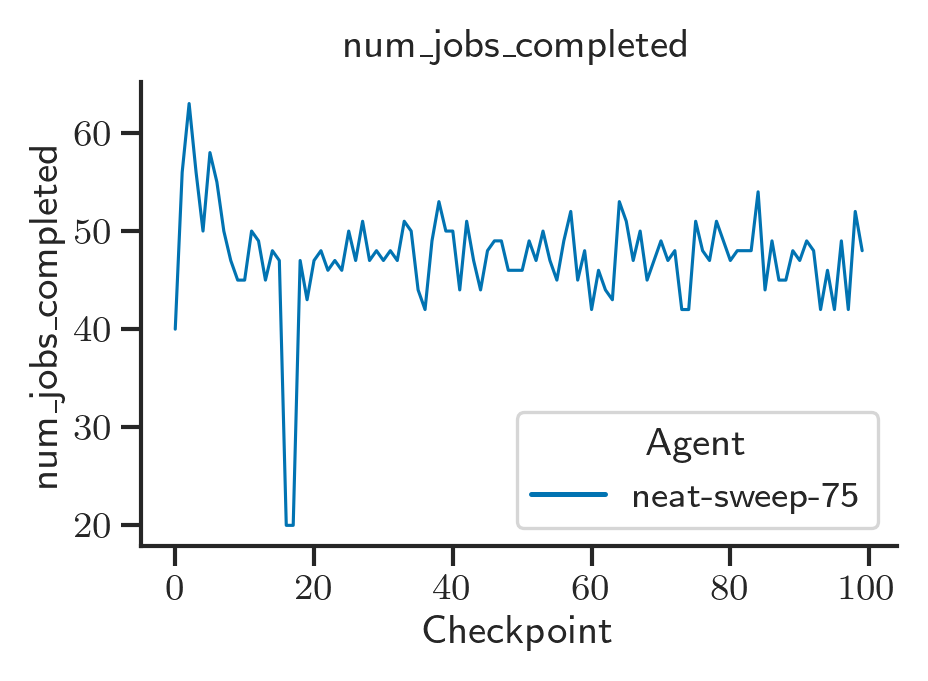

Metric num_jobs_arrived -> Min val: 100.0 | Min idx: 0 | Min checkpoint: 0 || Max val: 100.0 | Max idx: 0 | Max checkpoint: 0


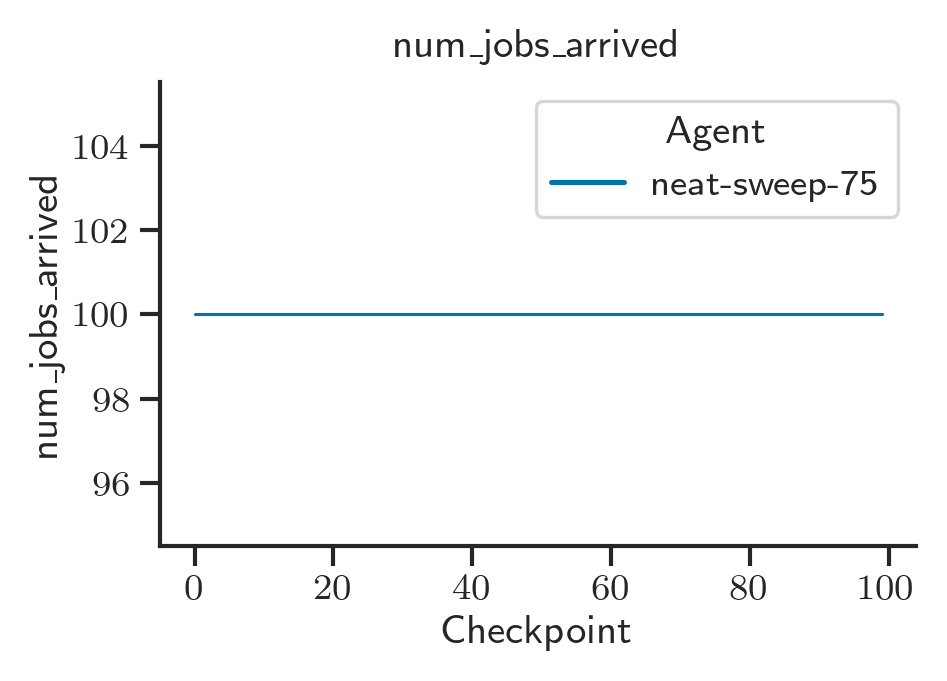

Metric return -> Min val: 0.000989566395253697 | Min idx: 16 | Min checkpoint: 16 || Max val: 0.022929078721579763 | Max idx: 90 | Max checkpoint: 90


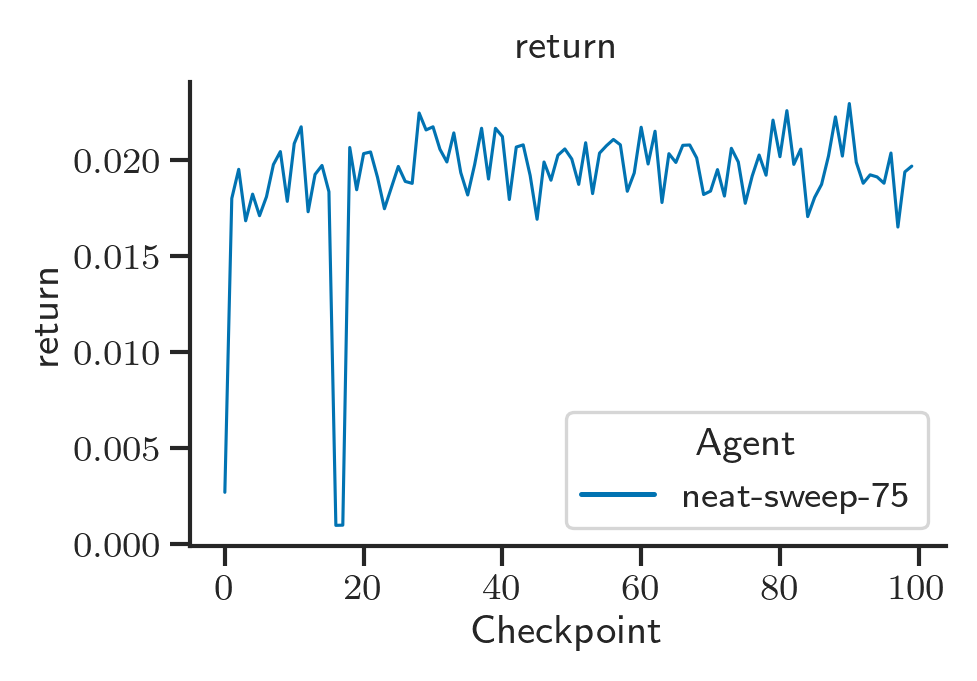

Metric mean_comm_throughput -> Min val: 1168692.7138246528 | Min idx: 17 | Min checkpoint: 17 || Max val: 39254145.657363184 | Max idx: 95 | Max checkpoint: 95


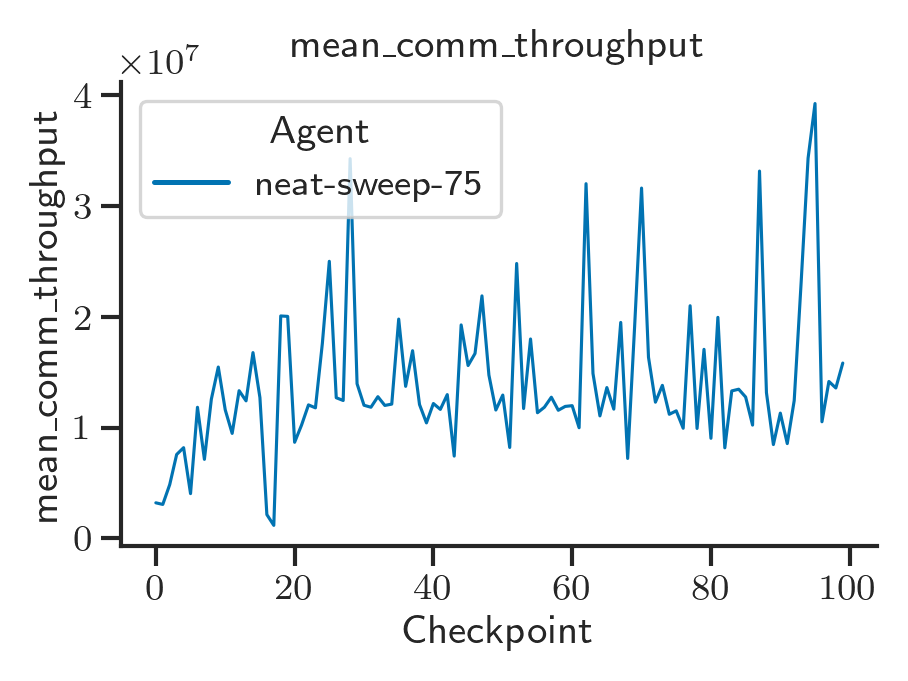

Metric num_jobs_blocked -> Min val: 37.0 | Min idx: 2 | Min checkpoint: 2 || Max val: 80.0 | Max idx: 16 | Max checkpoint: 16


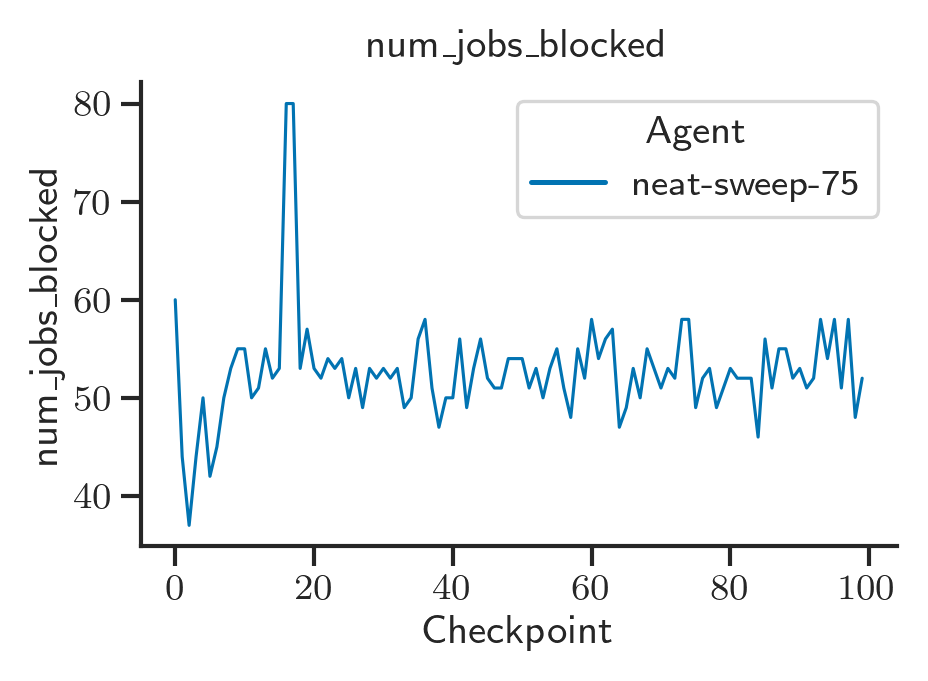

Metric mean_compute_throughput -> Min val: 399827.271584708 | Min idx: 17 | Min checkpoint: 17 || Max val: 8855206.768260218 | Max idx: 95 | Max checkpoint: 95


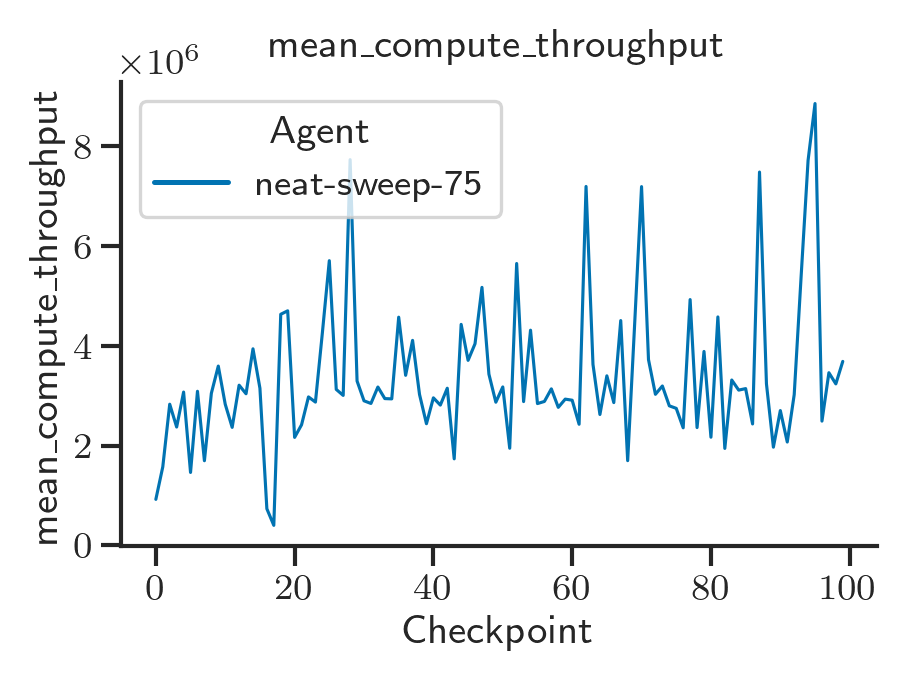

Metric mean_cluster_throughput -> Min val: 1568519.9854093606 | Min idx: 17 | Min checkpoint: 17 || Max val: 48109352.4256234 | Max idx: 95 | Max checkpoint: 95


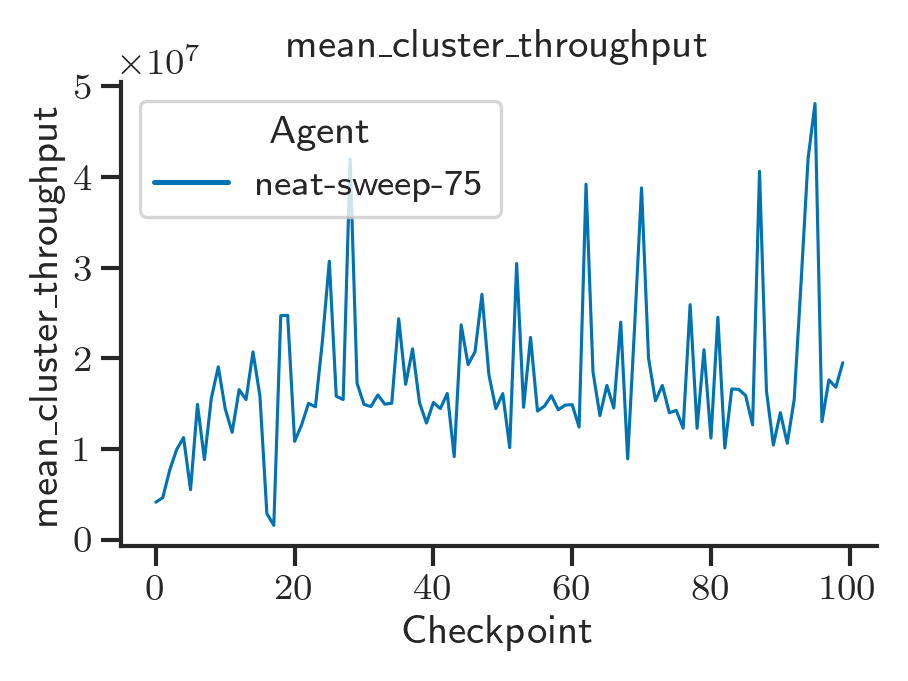

Metric job_computation_overhead_time -> Min val: 4470.800000000002 | Min idx: 16 | Min checkpoint: 16 || Max val: 14771.47294958483 | Max idx: 5 | Max checkpoint: 5


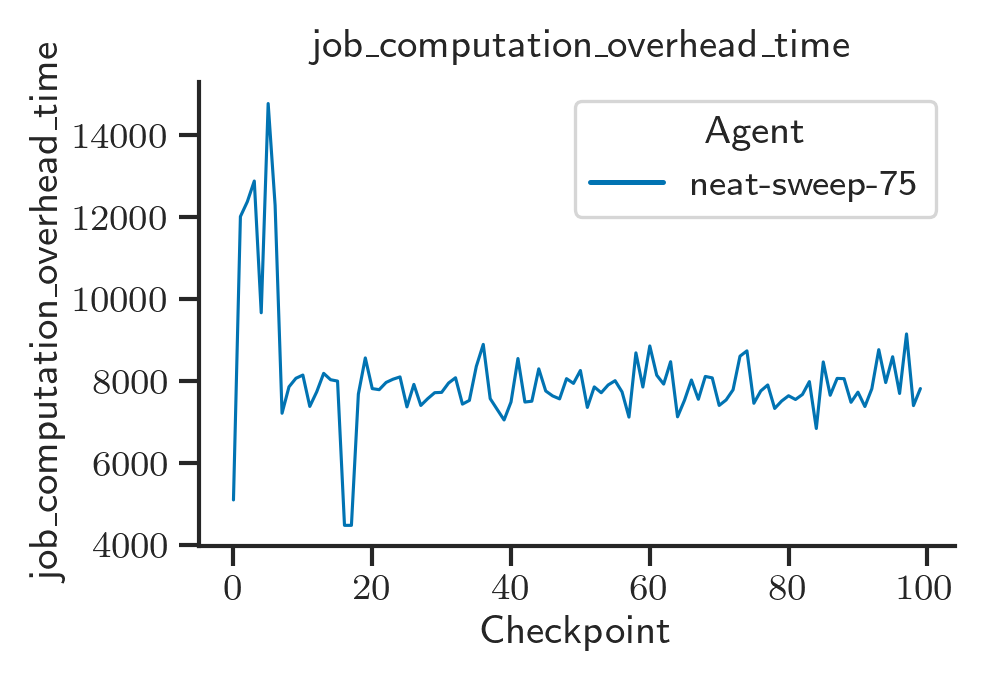

Metric jobs_completed_num_nodes -> Min val: 255.35 | Min idx: 0 | Min checkpoint: 0 || Max val: 722.2857142857143 | Max idx: 60 | Max checkpoint: 60


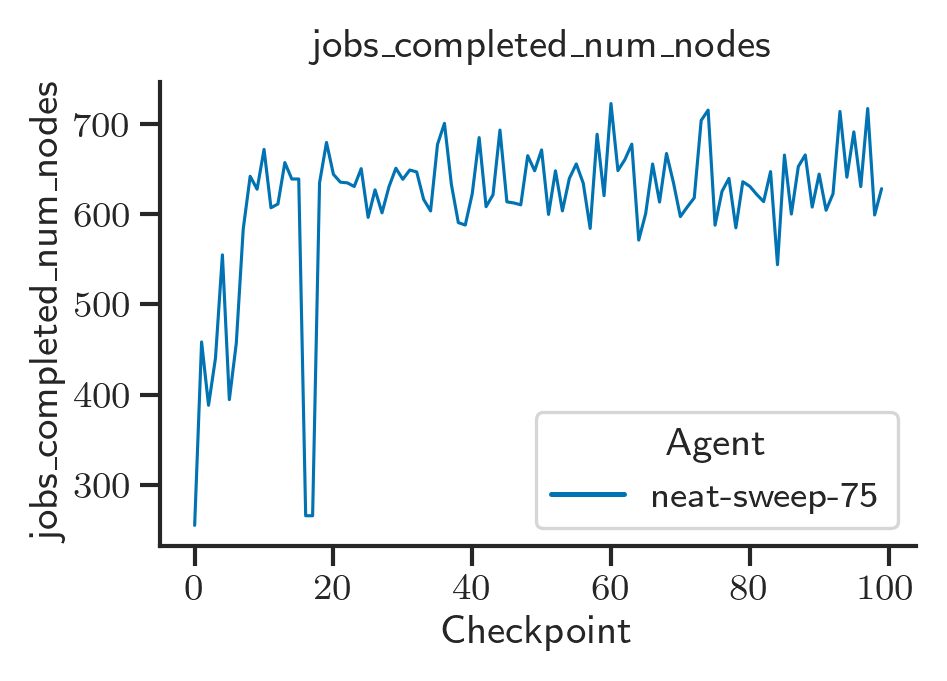

Metric job_completion_time -> Min val: 4470.800000000003 | Min idx: 16 | Min checkpoint: 16 || Max val: 14869.602952773173 | Max idx: 5 | Max checkpoint: 5


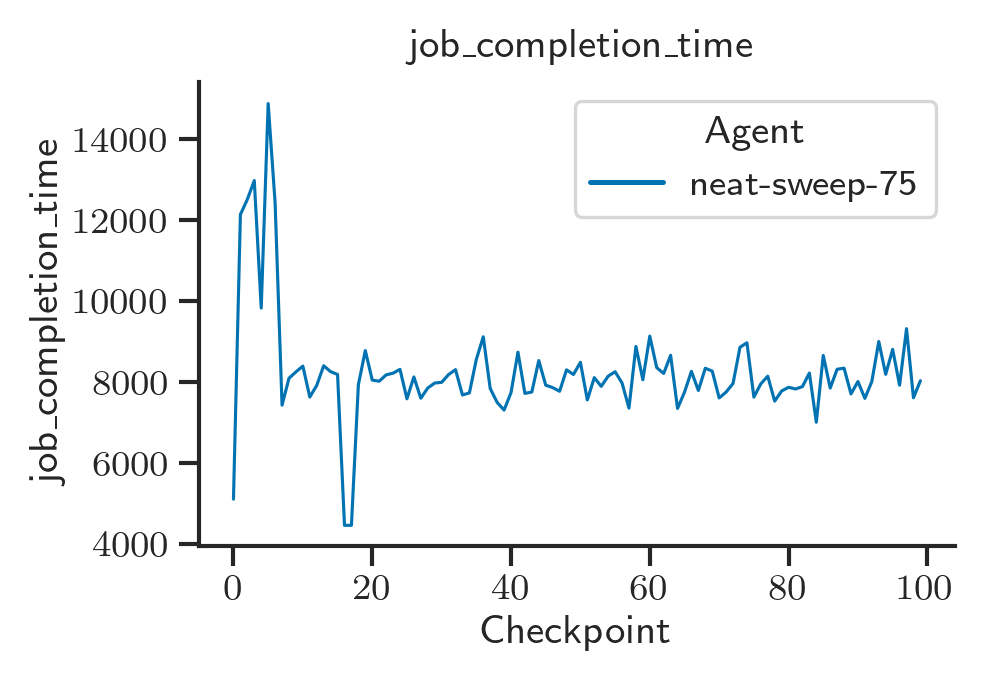

Metric jobs_completed_num_edges -> Min val: 1452.0 | Min idx: 16 | Min checkpoint: 16 || Max val: 7473.547619047619 | Max idx: 60 | Max checkpoint: 60


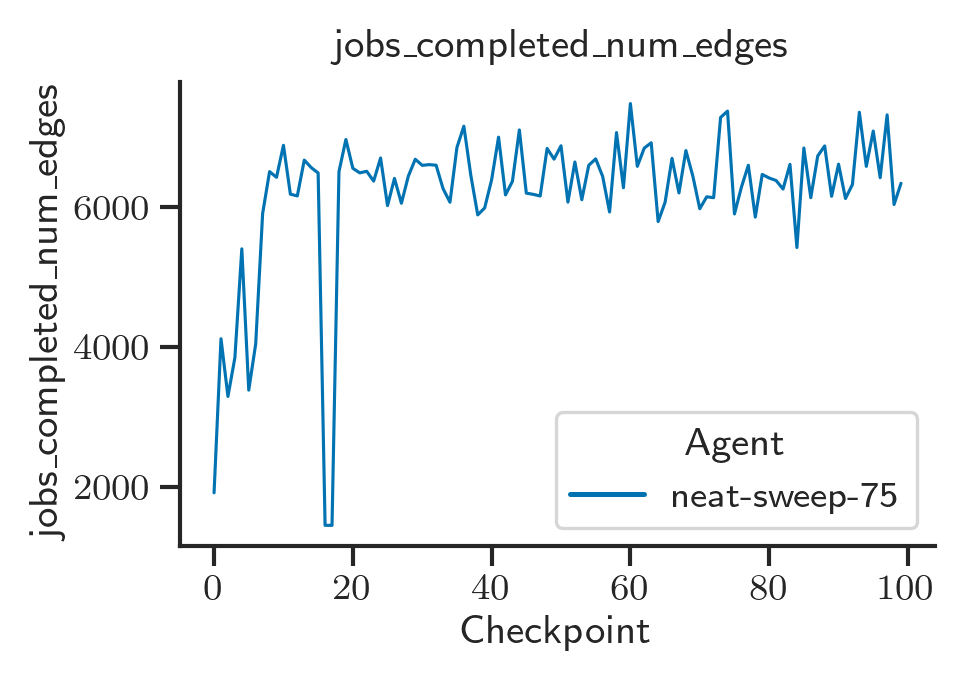

Metric job_communication_overhead_time -> Min val: 4470.800000000002 | Min idx: 16 | Min checkpoint: 16 || Max val: 14869.602952773173 | Max idx: 5 | Max checkpoint: 5


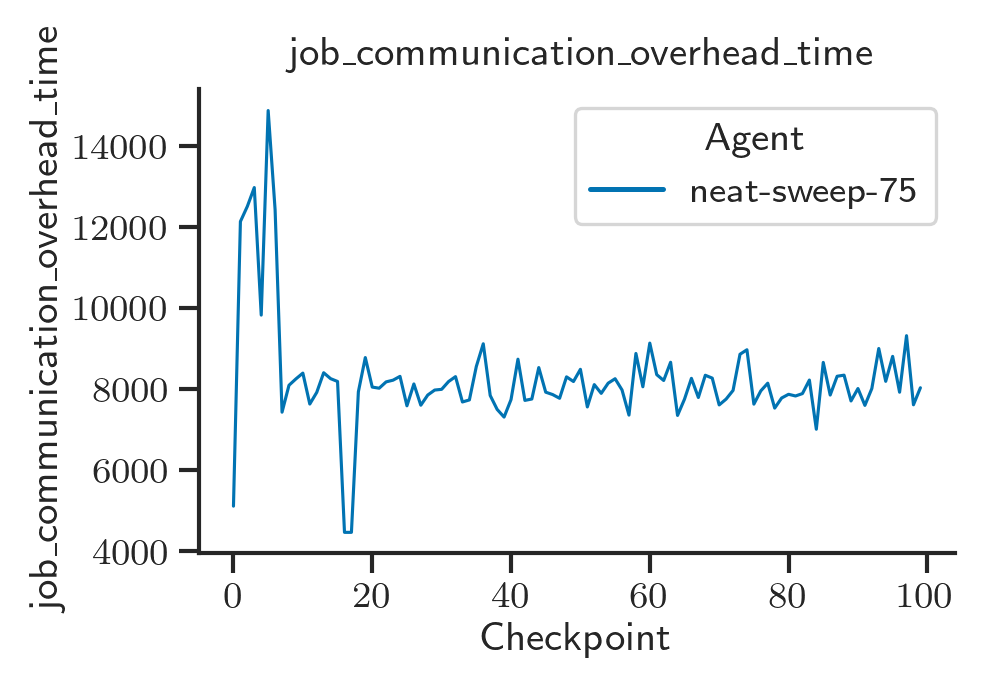

Metric jobs_completed_total_operation_memory_cost -> Min val: 2368446976.000008 | Min idx: 16 | Min checkpoint: 16 || Max val: 19361152276.761906 | Max idx: 60 | Max checkpoint: 60


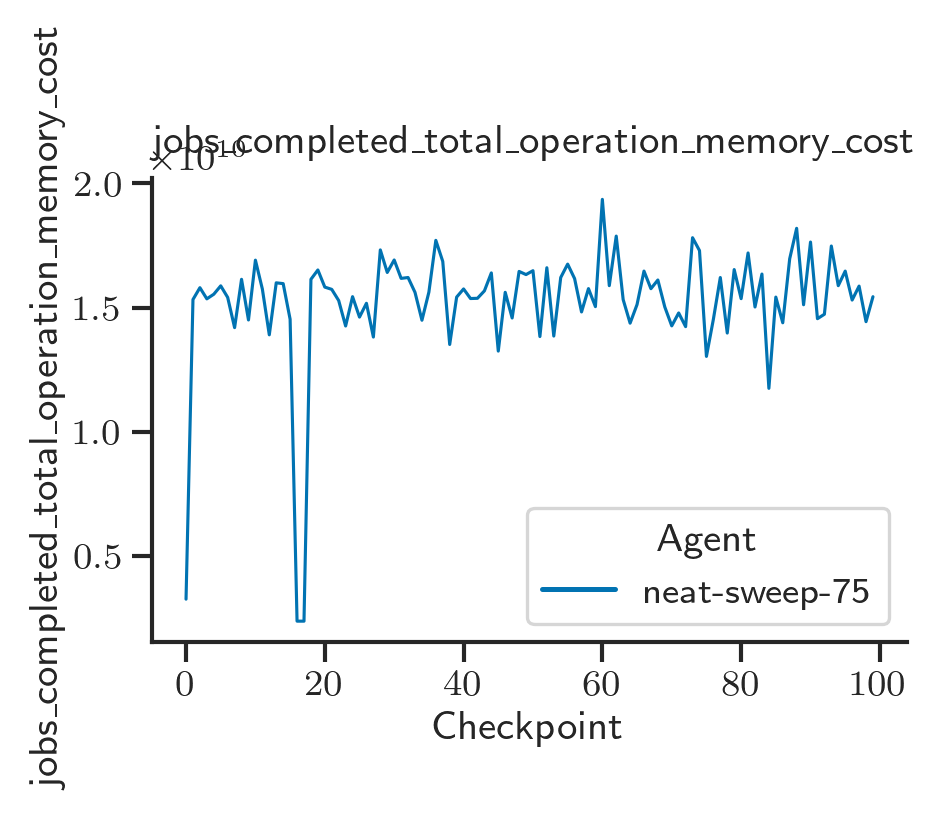

Metric jobs_completed_total_dependency_size -> Min val: 6922956288.0000105 | Min idx: 16 | Min checkpoint: 16 || Max val: 81729708061.61905 | Max idx: 60 | Max checkpoint: 60


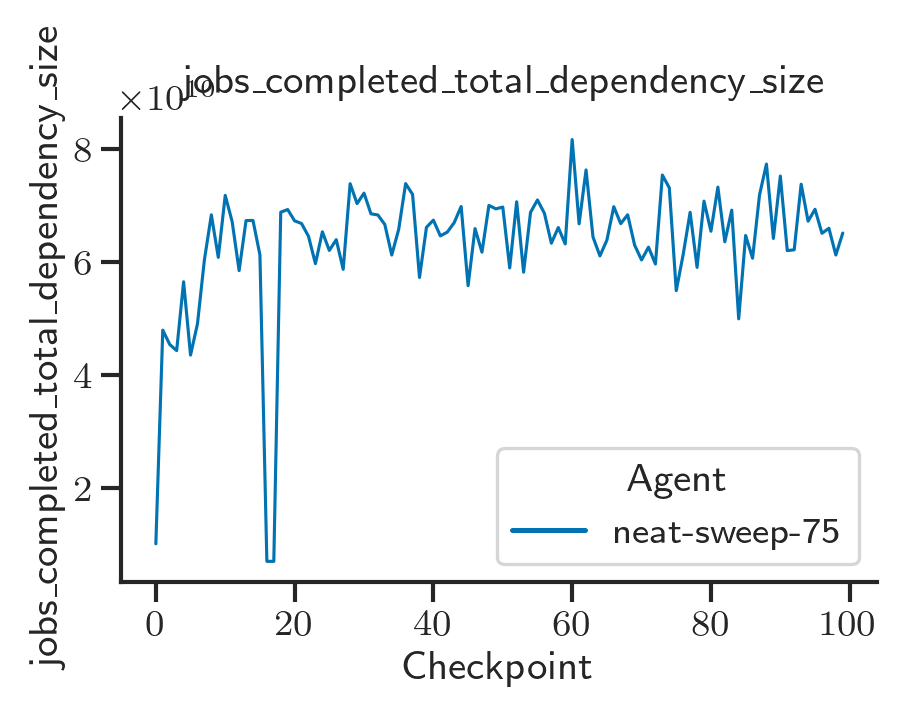

Metric jobs_blocked_total_operation_memory_cost -> Min val: 12966496296.137932 | Min idx: 60 | Min checkpoint: 60 || Max val: 23916919402.133335 | Max idx: 0 | Max checkpoint: 0


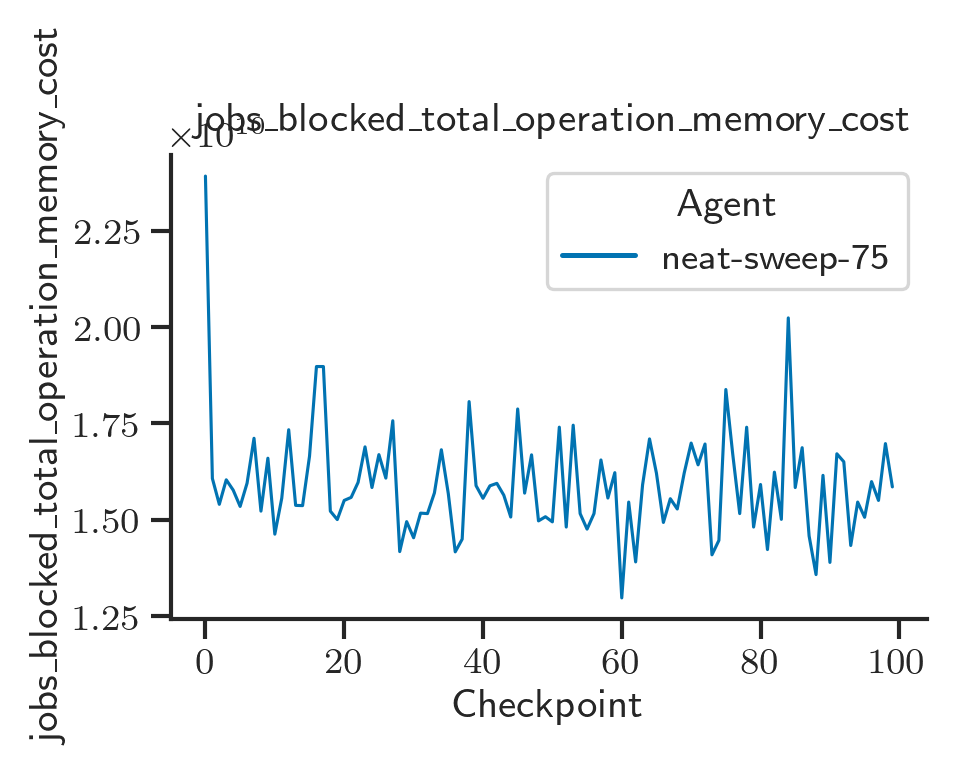

Metric jobs_blocked_num_edges -> Min val: 101.48275862068965 | Min idx: 97 | Min checkpoint: 97 || Max val: 129.9 | Max idx: 0 | Max checkpoint: 0


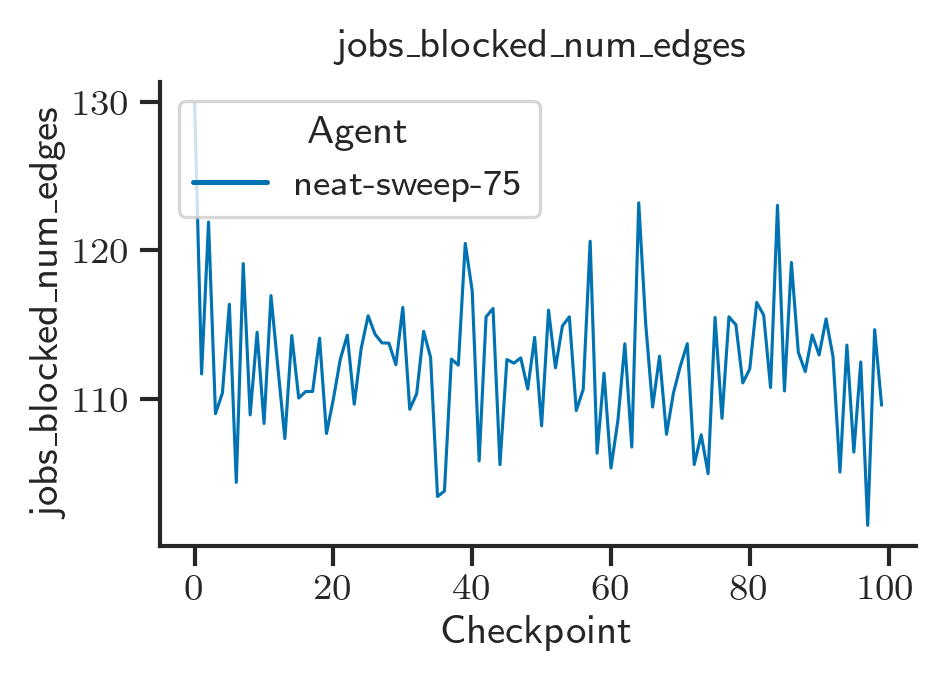

Metric jobs_blocked_total_dependency_size -> Min val: 12894083148.551723 | Min idx: 60 | Min checkpoint: 60 || Max val: 24945347250.666668 | Max idx: 0 | Max checkpoint: 0


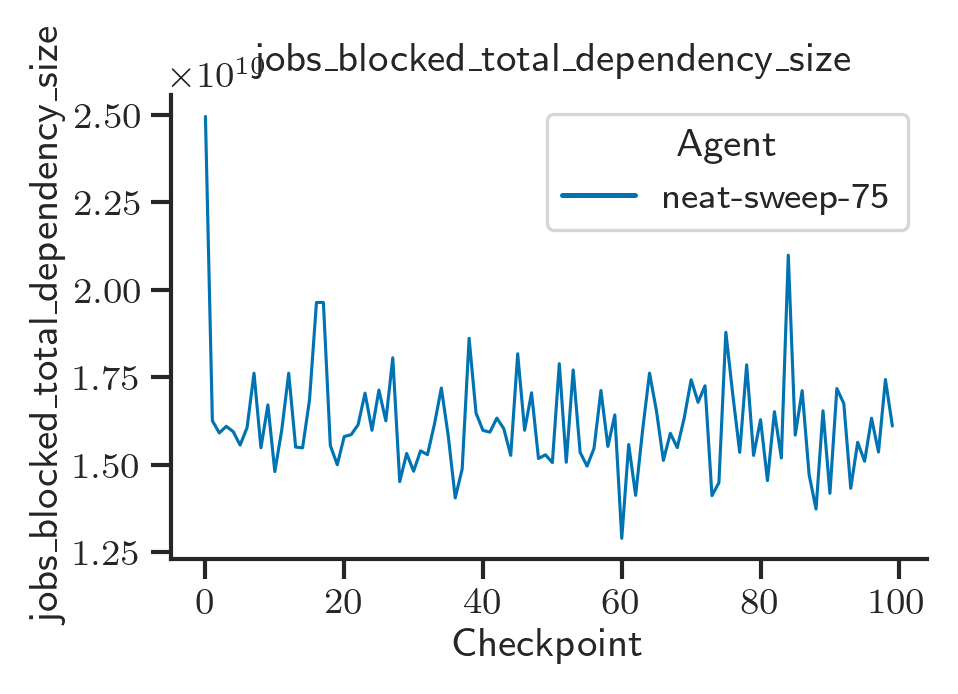

Metric jobs_blocked_num_nodes -> Min val: 91.93103448275862 | Min idx: 97 | Min checkpoint: 97 || Max val: 118.5 | Max idx: 0 | Max checkpoint: 0


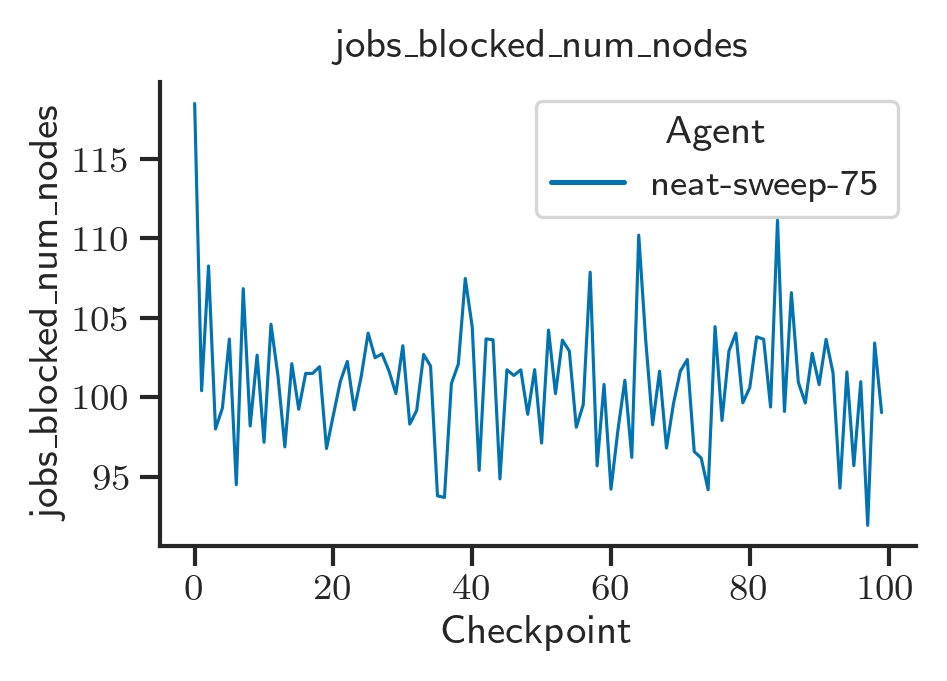



STEP METRICS
Metric comm_info_processed -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 323523073982.1838 | Max idx: 9799 | Max checkpoint: 97


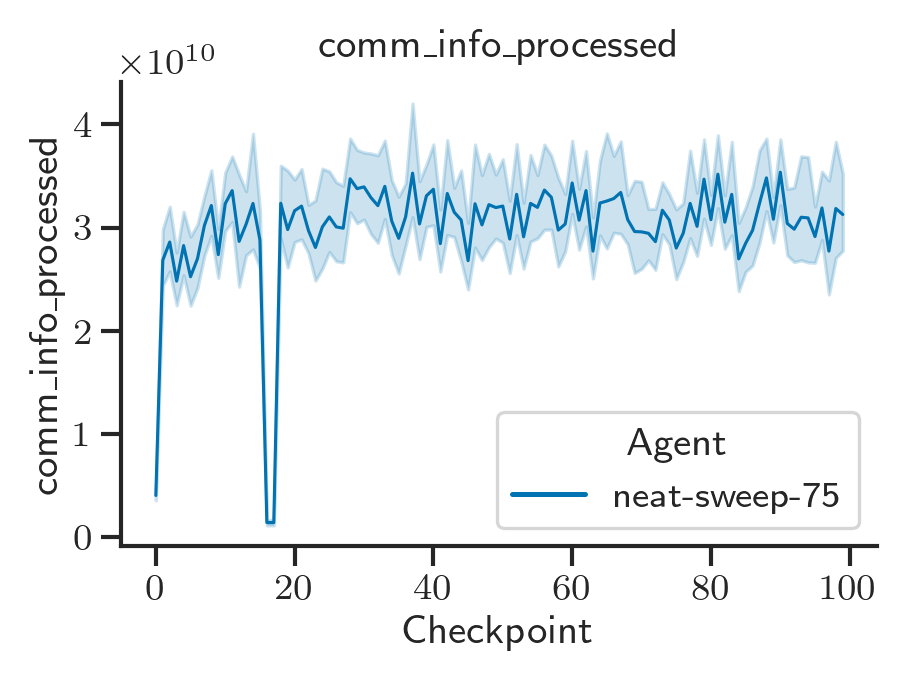

Metric compute_info_processed -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 76605202090.09177 | Max idx: 9799 | Max checkpoint: 97


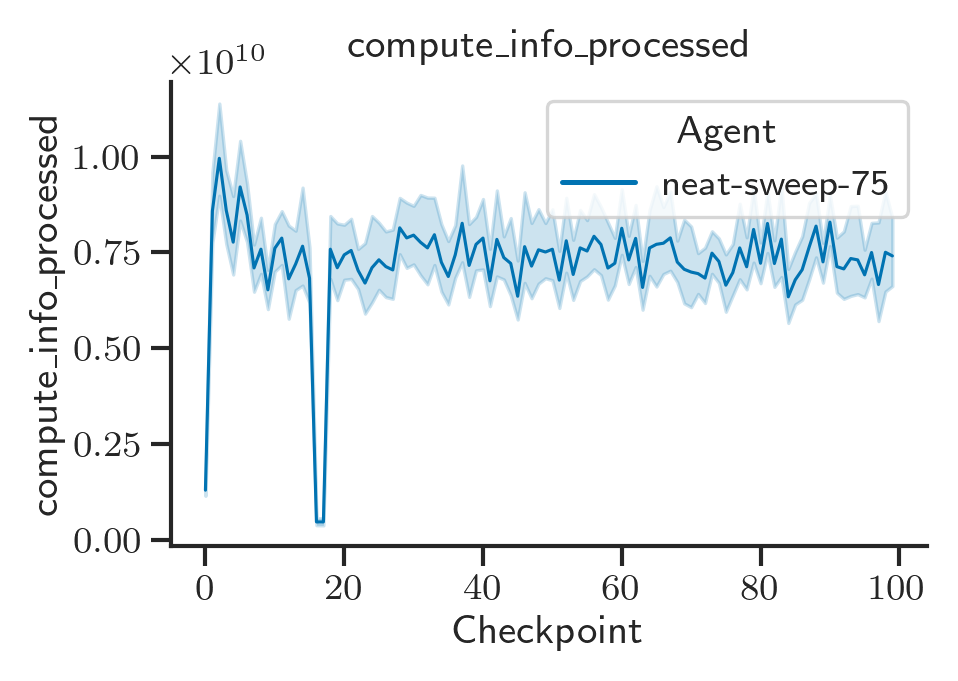

Metric mean_num_mounted_workers -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 32.0 | Max idx: 103 | Max checkpoint: 1


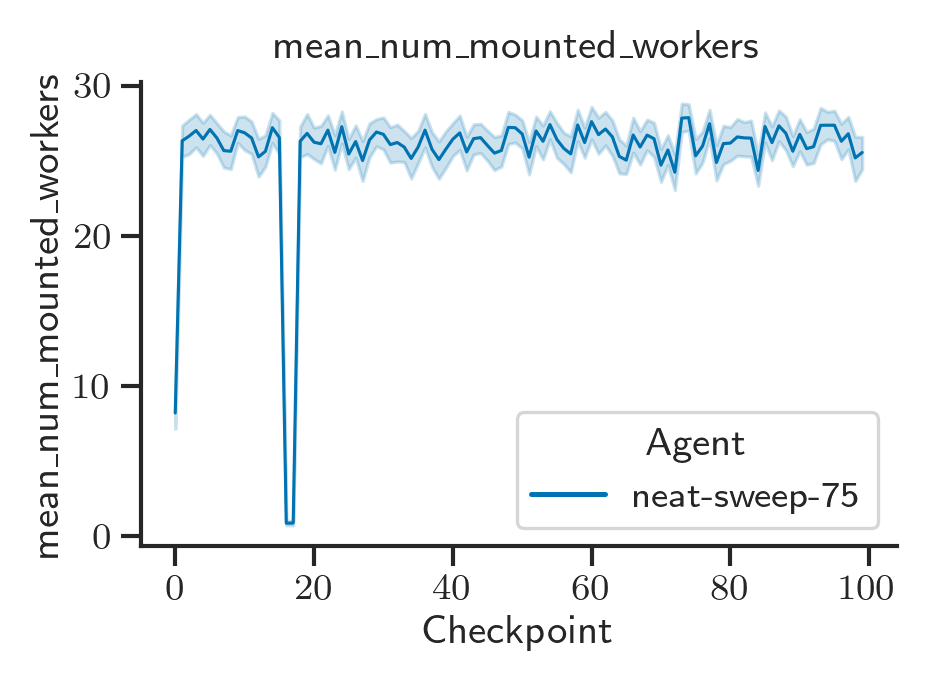

Metric mean_compute_throughput -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 18390025.23740005 | Max idx: 8154 | Max checkpoint: 81


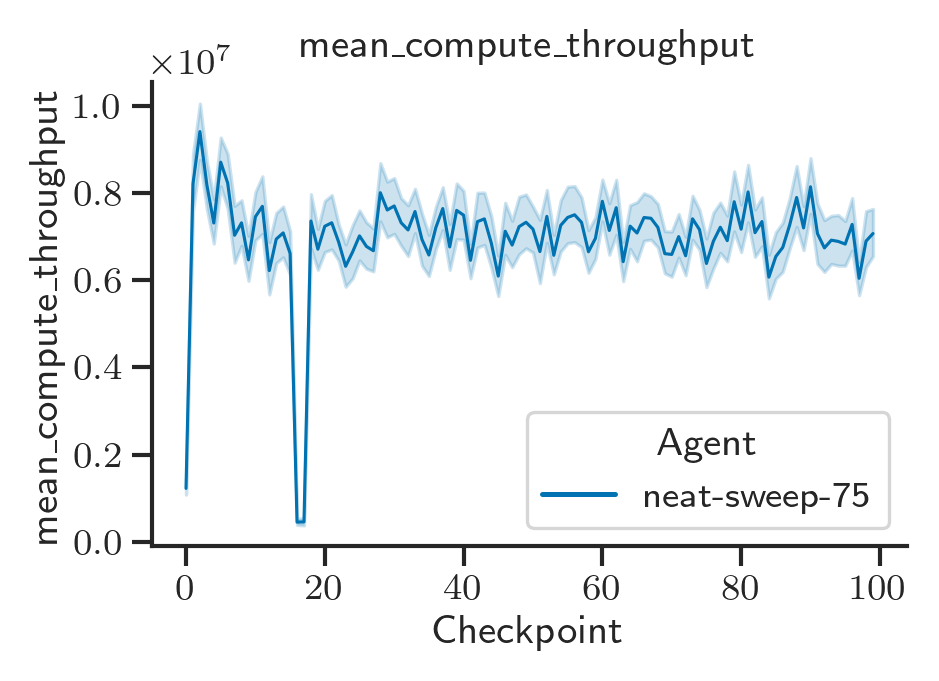

Metric job_queue_length -> Min val: 0 | Min idx: 99 | Min checkpoint: 0 || Max val: 1 | Max idx: 0 | Max checkpoint: 0


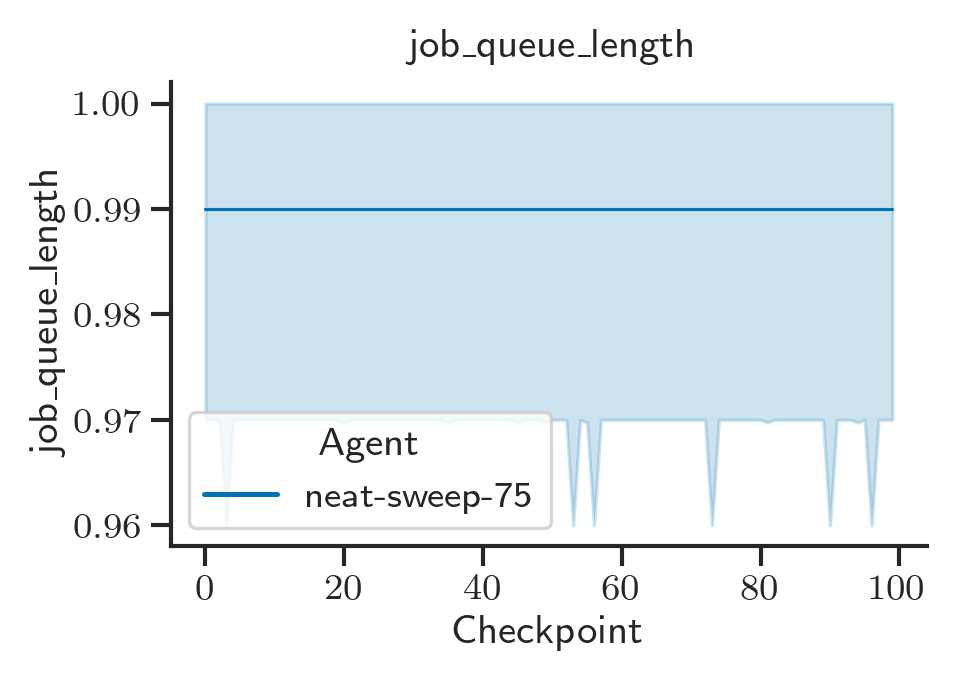

Metric mean_mounted_worker_utilisation_frac -> Min val: 0.3571286542227976 | Min idx: 100 | Min checkpoint: 1 || Max val: 1.000000000000001 | Max idx: 800 | Max checkpoint: 8


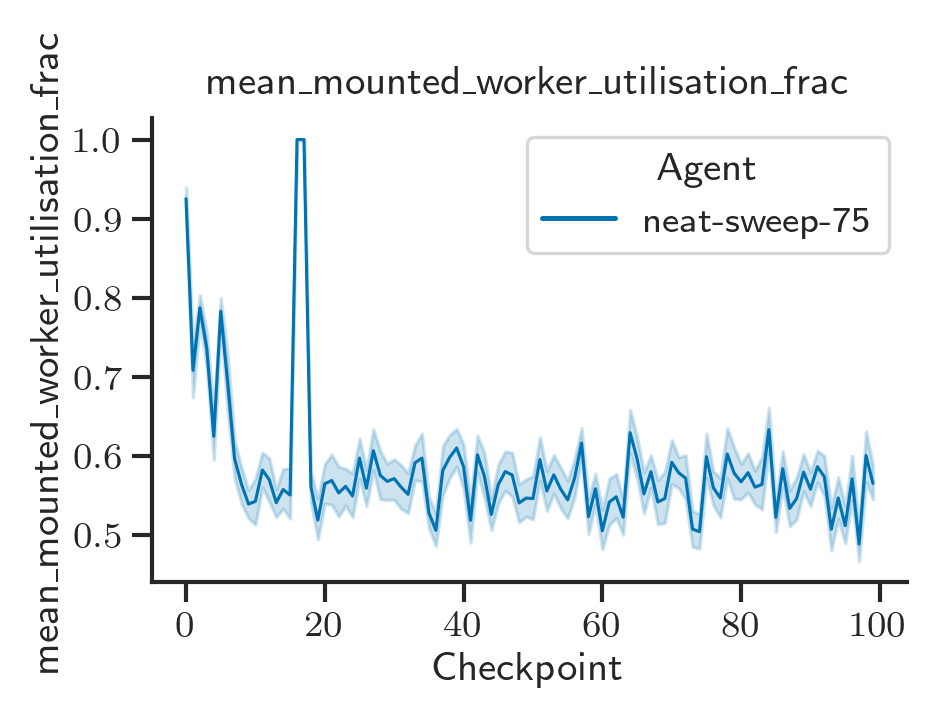

Metric num_jobs_completed -> Min val: 0 | Min idx: 0 | Min checkpoint: 0 || Max val: 7 | Max idx: 199 | Max checkpoint: 1


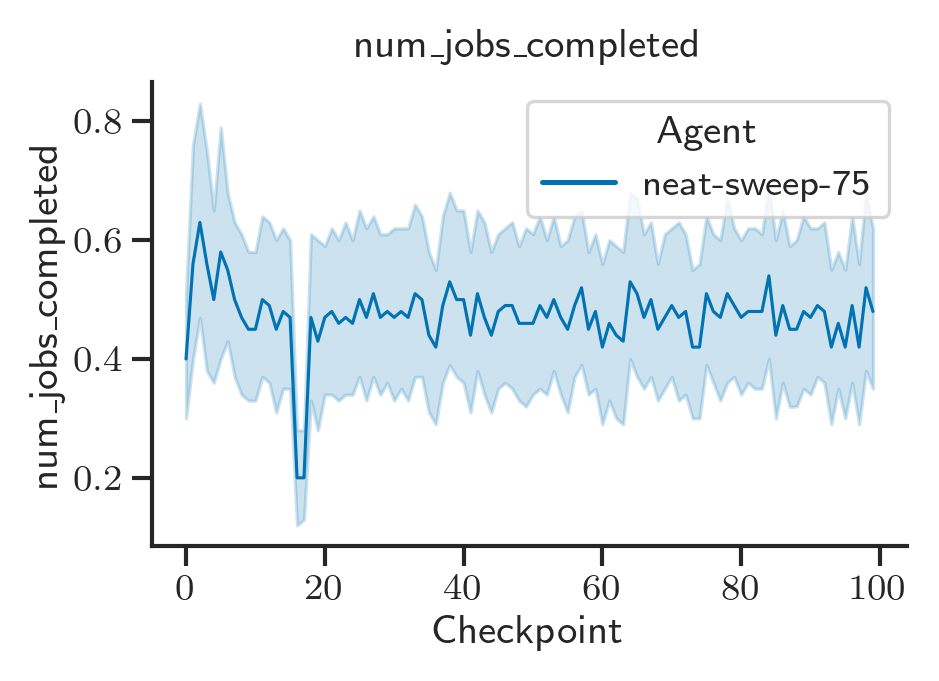

Metric num_jobs_arrived -> Min val: 0 | Min idx: 99 | Min checkpoint: 0 || Max val: 1 | Max idx: 0 | Max checkpoint: 0


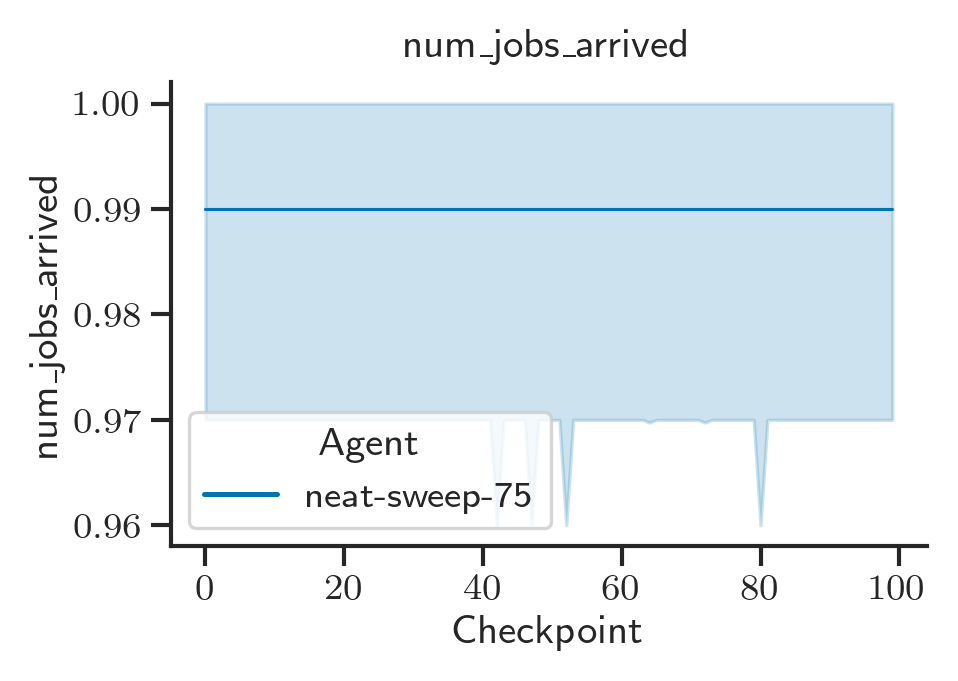

Metric mean_num_jobs_running -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 13.0 | Max idx: 235 | Max checkpoint: 2


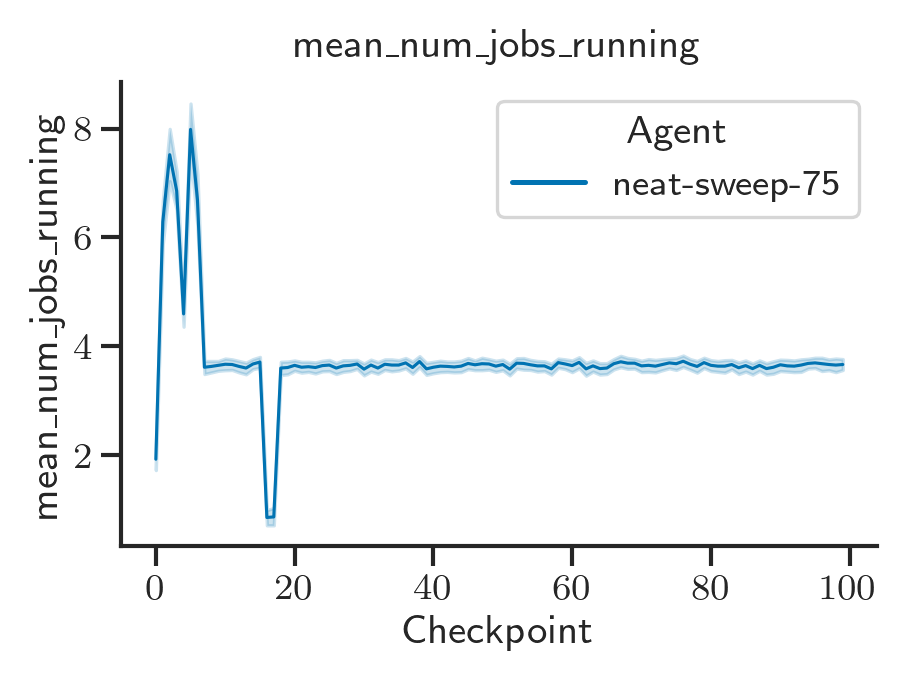

Metric step_end_time -> Min val: 1000.0 | Min idx: 0 | Min checkpoint: 0 || Max val: 134061.15 | Max idx: 599 | Max checkpoint: 5


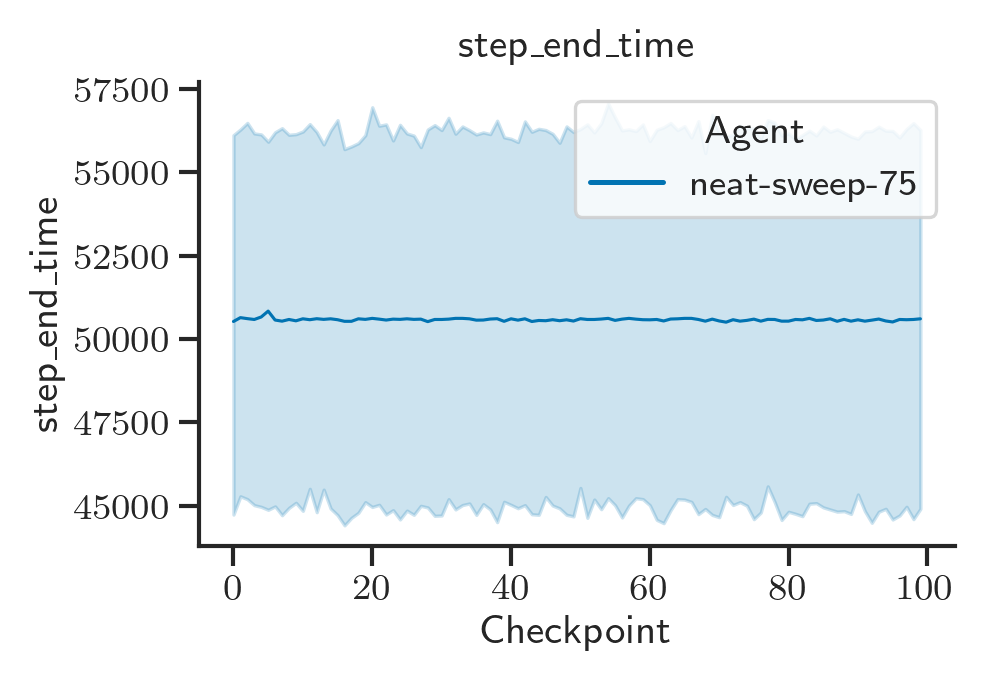

Metric mean_comm_throughput -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 81202189.17868665 | Max idx: 8154 | Max checkpoint: 81


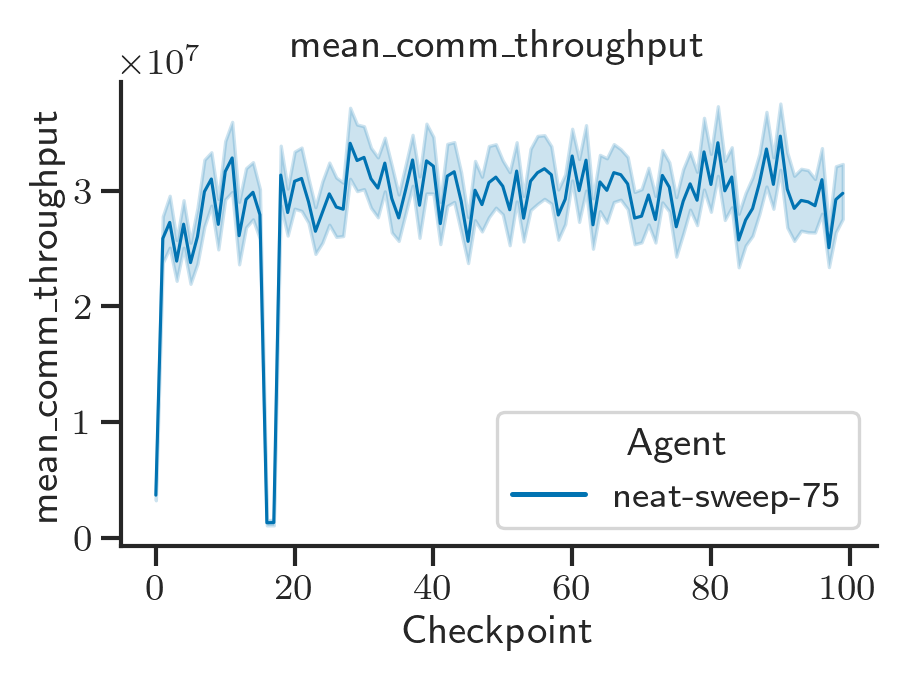

Metric reward -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 0.0004991725038465715 | Max idx: 5143 | Max checkpoint: 51


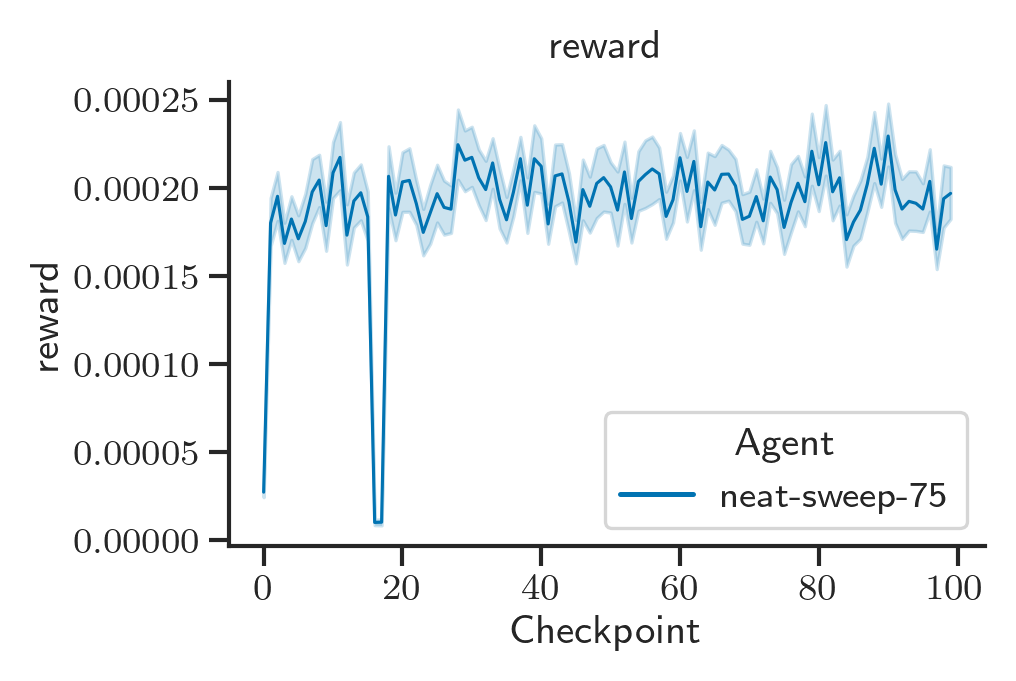

Metric mean_compute_overhead_frac -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 1.0 | Max idx: 0 | Max checkpoint: 0


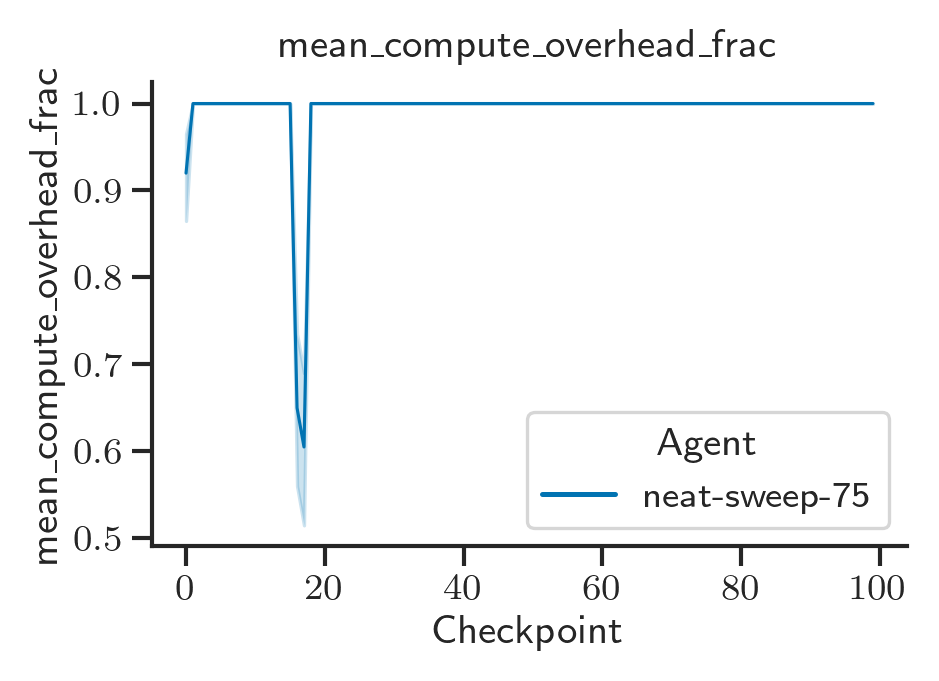

Metric mean_num_mounted_channels -> Min val: 0.0 | Min idx: 27 | Min checkpoint: 0 || Max val: 224.0 | Max idx: 103 | Max checkpoint: 1


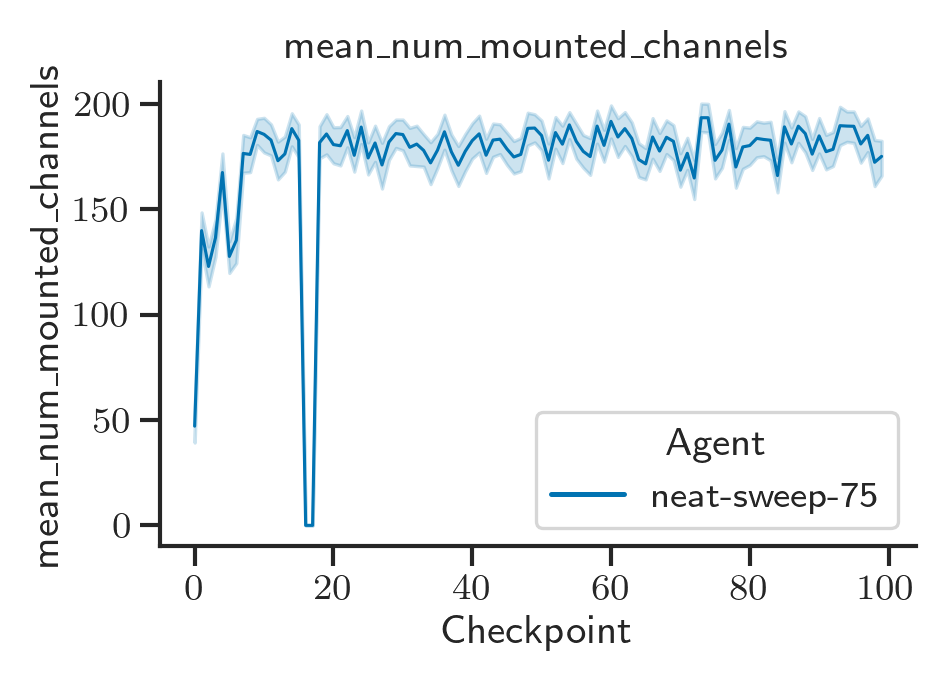

Metric action -> Min val: 0 | Min idx: 104 | Min checkpoint: 1 || Max val: 8 | Max idx: 0 | Max checkpoint: 0


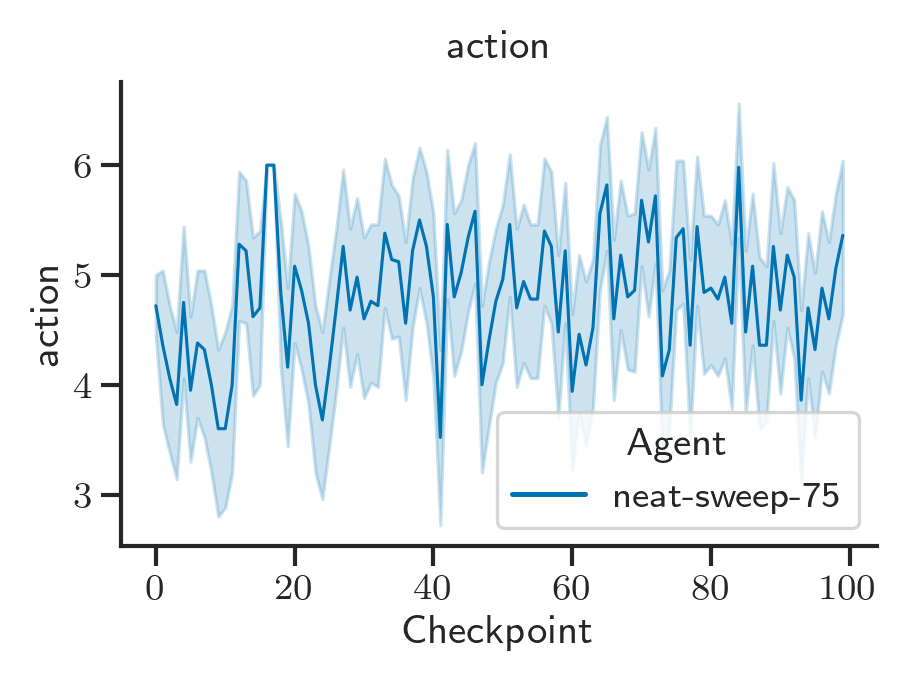

Metric cluster_info_processed -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 400128276072.2756 | Max idx: 9799 | Max checkpoint: 97


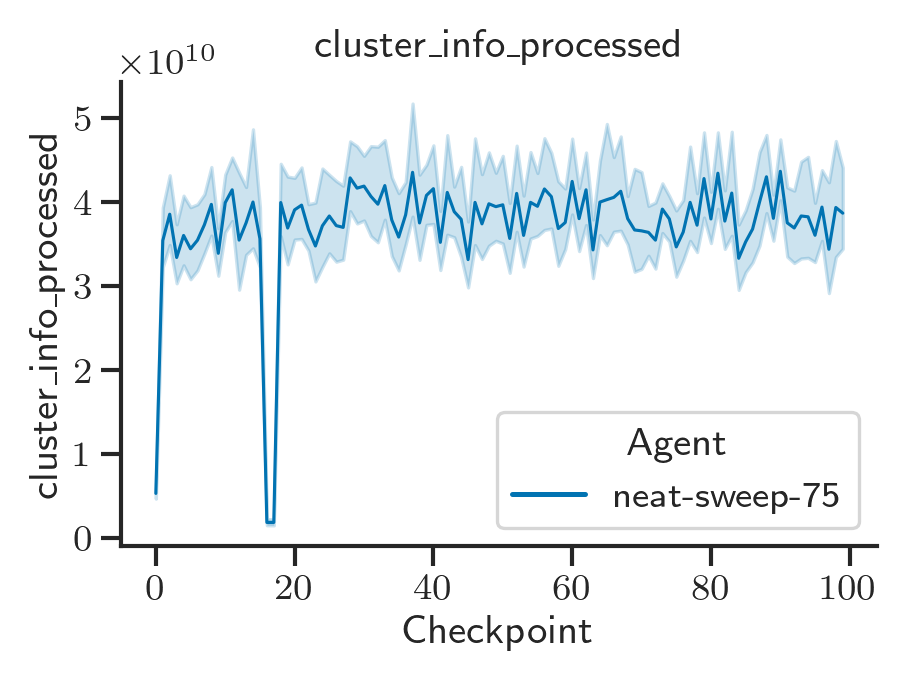

Metric num_jobs_blocked -> Min val: 0 | Min idx: 0 | Min checkpoint: 0 || Max val: 1 | Max idx: 1 | Max checkpoint: 0


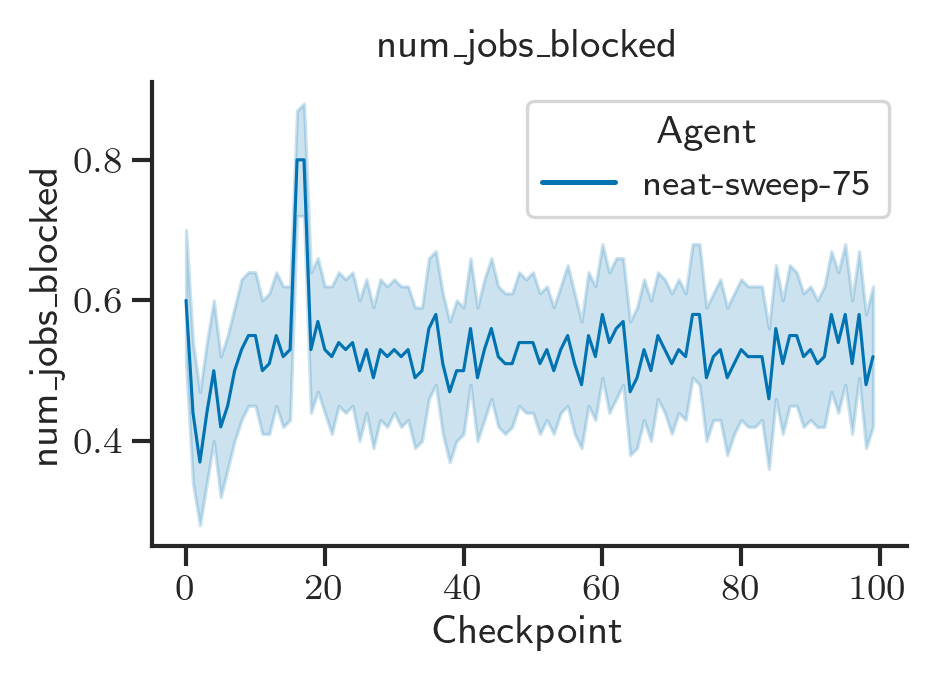

Metric step_start_time -> Min val: 0.0 | Min idx: 0 | Min checkpoint: 0 || Max val: 99000.0 | Max idx: 99 | Max checkpoint: 0


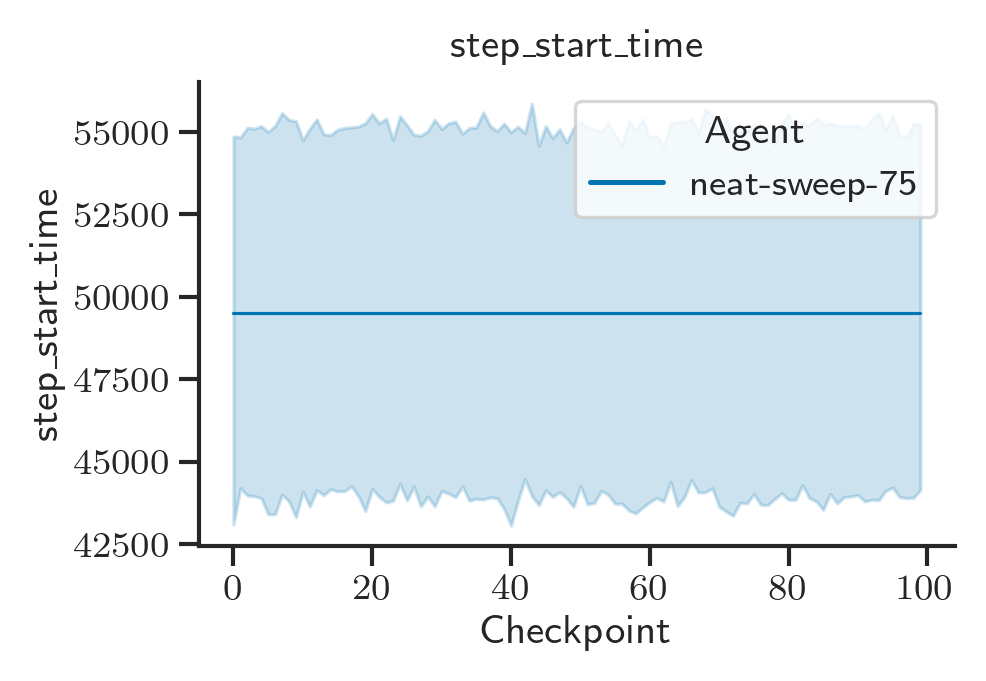

Metric mean_comm_overhead_frac -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 1.0 | Max idx: 27 | Max checkpoint: 0


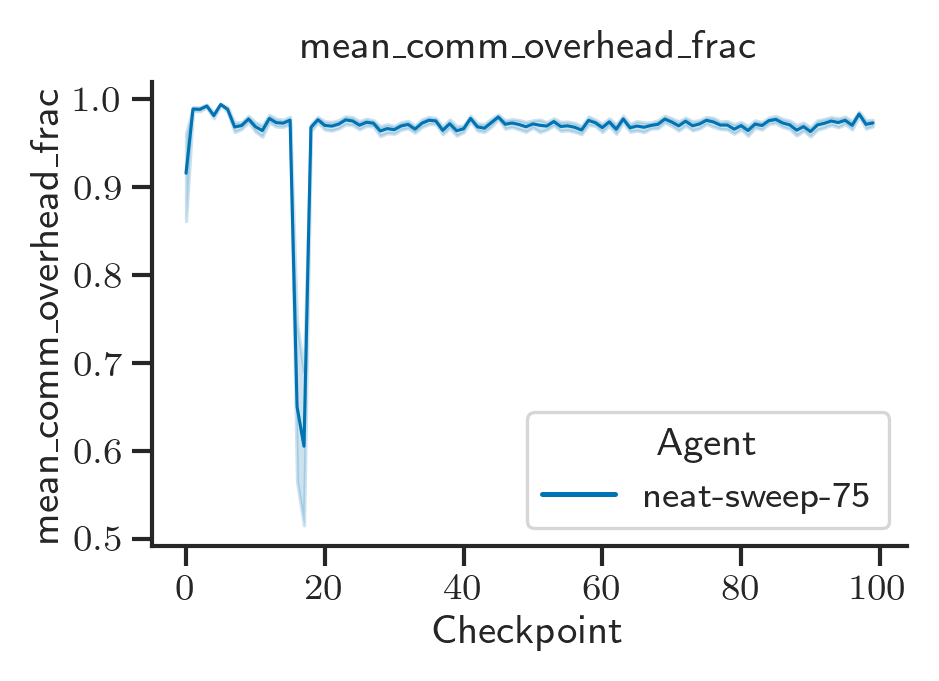

Metric step_counter -> Min val: 0 | Min idx: 0 | Min checkpoint: 0 || Max val: 161 | Max idx: 299 | Max checkpoint: 2


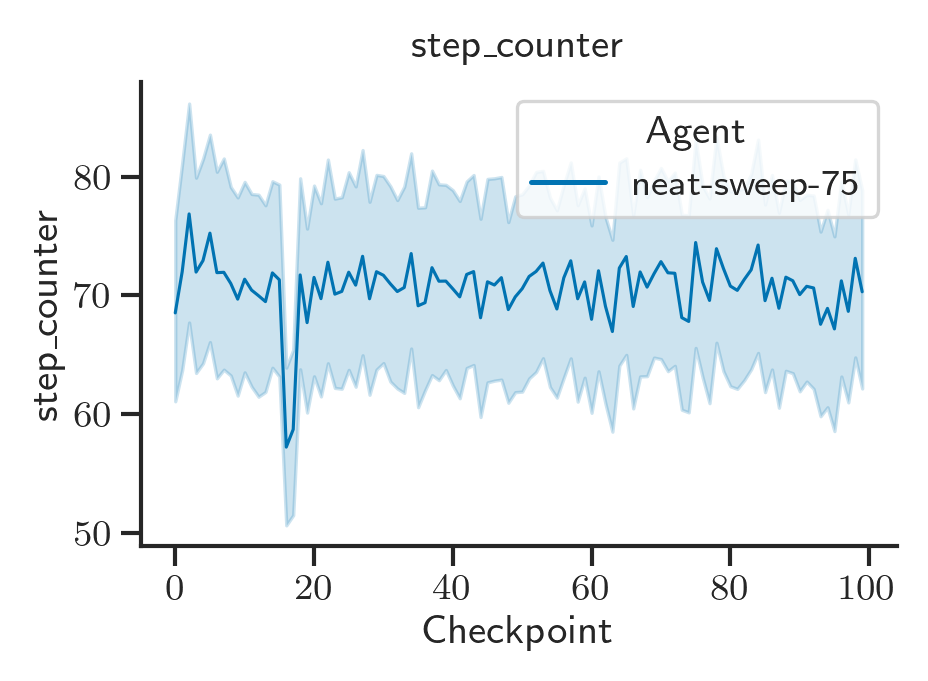

Metric mean_cluster_worker_utilisation_frac -> Min val: 0.031249999999999965 | Min idx: 27 | Min checkpoint: 0 || Max val: 0.8852742867371687 | Max idx: 242 | Max checkpoint: 2


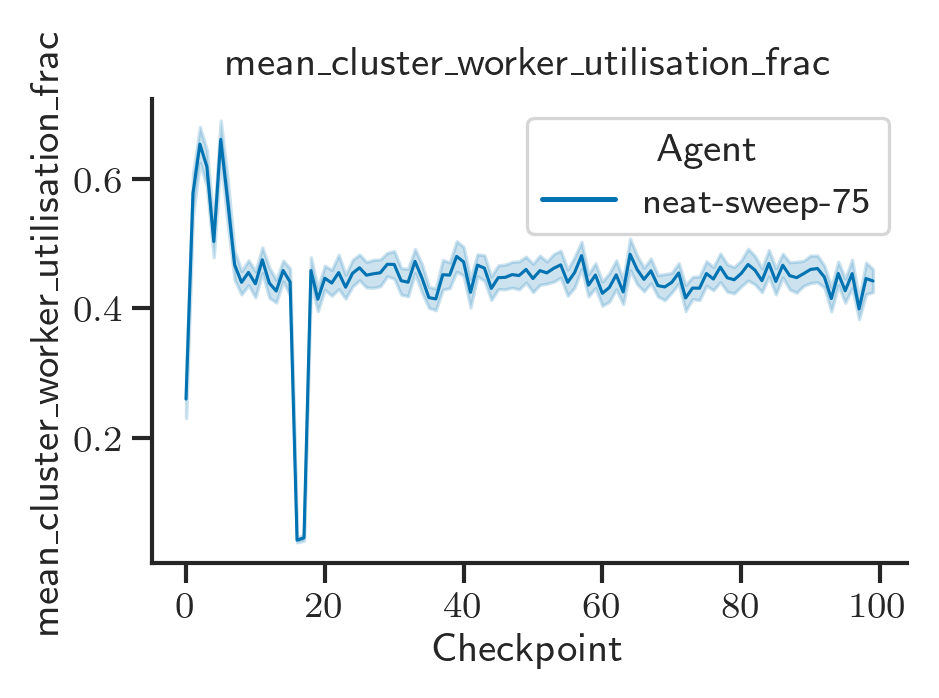

Metric mean_cluster_throughput -> Min val: 0.0 | Min idx: 29 | Min checkpoint: 0 || Max val: 99592214.41608669 | Max idx: 4874 | Max checkpoint: 48


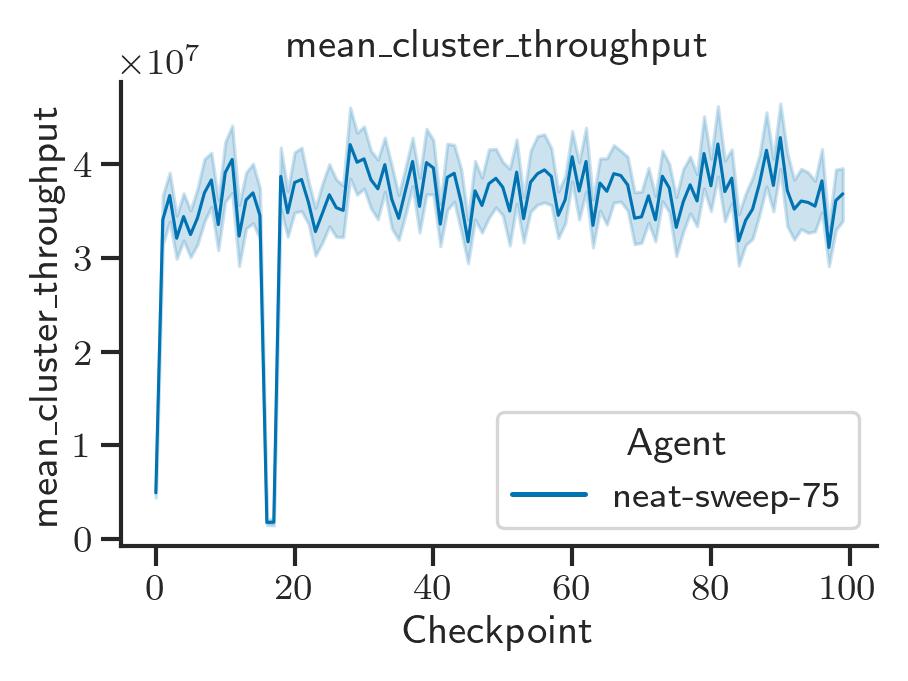

In [42]:
print(f'\n\nEPISODE METRICS')
for metric in episode_metrics:
    lineplot(df=episode_stats_df, metric=metric)
if len(episode_completion_stats_df) > 0:
    for metric in episode_completion_metrics:
        lineplot(df=episode_completion_stats_df, metric=metric)
if len(episode_blocked_stats_df) > 0:
    for metric in episode_blocked_metrics:
        lineplot(df=episode_blocked_stats_df, metric=metric)
    
print(f'\n\nSTEP METRICS')
for metric in step_metrics:
    lineplot(df=step_stats_df, metric=metric)